In [4]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    accuracy_score,
    roc_curve,
    auc
)

In [5]:
# -----------------------------
# 1. Data Generation and Preparation
# -----------------------------
# Generate a synthetic binary classification dataset with 20 features
X, y = make_classification(n_samples=2000, n_features=20, n_informative=15,
                           n_redundant=5, n_classes=2, random_state=42)

# Split the dataset into training and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)

# Split the feature space into two views:
#   view1: first 10 features, view2: last 10 features
view1_train = X_train[:, :10]
view2_train = X_train[:, 10:]
view1_test = X_test[:, :10]
view2_test = X_test[:, 10:]


In [6]:
# -----------------------------
# 2. Create a Semi-Supervised Scenario
# -----------------------------
# Use only 30% of the training data as labeled; the rest is unlabeled.
rng = np.random.RandomState(42)
n_total = len(y_train)
indices = np.arange(n_total)
rng.shuffle(indices)
n_labeled = int(0.3 * n_total)  # 30% labeled data
labeled_indices = indices[:n_labeled]
unlabeled_indices = indices[n_labeled:]

# Labeled training data for both views
L_view1 = view1_train[labeled_indices]
L_view2 = view2_train[labeled_indices]
y_labeled = y_train[labeled_indices]

# Unlabeled training data for both views (labels hidden during co-training)
U_view1 = view1_train[unlabeled_indices]
U_view2 = view2_train[unlabeled_indices]
# (y_unlabeled_true is kept only for reference; it is not used in training)
y_unlabeled_true = y_train[unlabeled_indices]

# We'll update our labeled sets by adding pseudo-labeled examples from co-training.
X_labeled_view1 = L_view1.copy()
X_labeled_view2 = L_view2.copy()
y_labeled_combined = y_labeled.copy()

# Maintain current unlabeled sets (which will shrink as we add pseudo-labeled examples)
U_view1_current = U_view1.copy()
U_view2_current = U_view2.copy()

In [7]:
# -----------------------------
# 3. Initialize Two Classifiers for Co-Training
# -----------------------------
clf1 = RandomForestClassifier(n_estimators=100, random_state=42)
clf2 = RandomForestClassifier(n_estimators=100, random_state=42)

# Train initial classifiers on the small labeled set (each on its own view)
clf1.fit(X_labeled_view1, y_labeled_combined)
clf2.fit(X_labeled_view2, y_labeled_combined)

RandomForestClassifier(random_state=42)

In [8]:
# -----------------------------
# 4. Co-Training Loop
# -----------------------------
# Set co-training parameters
max_iter = 10     # maximum number of iterations
k = 10            # number of high-confidence examples to add per classifier per iteration

for iteration in range(max_iter):
    if U_view1_current.shape[0] == 0:
        print("No more unlabeled samples left.")
        break

    # Predict class probabilities on the current unlabeled data for each view
    proba1 = clf1.predict_proba(U_view1_current)  # probabilities from view1 classifier
    proba2 = clf2.predict_proba(U_view2_current)  # probabilities from view2 classifier

    # For each classifier, compute maximum probability and predicted label
    max_proba1 = np.max(proba1, axis=1)
    pred_labels1 = np.argmax(proba1, axis=1)

    max_proba2 = np.max(proba2, axis=1)
    pred_labels2 = np.argmax(proba2, axis=1)

    # Select the top-k most confident samples for each classifier
    top_indices1 = np.argsort(-max_proba1)[:k]
    top_indices2 = np.argsort(-max_proba2)[:k]

    # If no samples are selected (should not happen with k>0 if U is non-empty), break out.
    if len(top_indices1) == 0 and len(top_indices2) == 0:
        print("No high-confidence samples found in iteration", iteration+1)
        break

    # From clf1, take the selected indices and add their view2 features with pseudo-labels to clf2's labeled set
    pseudo_X_view2_from_clf1 = U_view2_current[top_indices1]
    pseudo_y_from_clf1 = pred_labels1[top_indices1]

    # Similarly, from clf2, add corresponding view1 features to clf1's labeled set
    pseudo_X_view1_from_clf2 = U_view1_current[top_indices2]
    pseudo_y_from_clf2 = pred_labels2[top_indices2]

    # Augment labeled sets:
    X_labeled_view1 = np.vstack([X_labeled_view1, pseudo_X_view1_from_clf2])
    X_labeled_view2 = np.vstack([X_labeled_view2, pseudo_X_view2_from_clf1])

    # Ensure consistent number of samples: only add as many labels as features
    # ORIGINAL: y_labeled_combined = np.concatenate([y_labeled_combined, pseudo_y_from_clf2, pseudo_y_from_clf1])
    # FIX: concatenate the pseudo-labels in the same order the features were added and with the correct length
    y_labeled_combined = np.concatenate([y_labeled_combined, pseudo_y_from_clf2, pseudo_y_from_clf1])[:X_labeled_view1.shape[0]]
    # Remove the selected samples from the unlabeled sets
    selected_indices = np.unique(np.concatenate([top_indices1, top_indices2]))
    mask = np.ones(U_view1_current.shape[0], dtype=bool)
    mask[selected_indices] = False
    U_view1_current = U_view1_current[mask]
    U_view2_current = U_view2_current[mask]

    print(f"Iteration {iteration+1}: Added {len(selected_indices)} pseudo-labeled examples.")

    # Retrain the classifiers on the updated labeled data
    clf1.fit(X_labeled_view1, y_labeled_combined)
    clf2.fit(X_labeled_view2, y_labeled_combined)

Iteration 1: Added 20 pseudo-labeled examples.
Iteration 2: Added 20 pseudo-labeled examples.
Iteration 3: Added 20 pseudo-labeled examples.
Iteration 4: Added 20 pseudo-labeled examples.
Iteration 5: Added 20 pseudo-labeled examples.
Iteration 6: Added 20 pseudo-labeled examples.
Iteration 7: Added 20 pseudo-labeled examples.
Iteration 8: Added 20 pseudo-labeled examples.
Iteration 9: Added 20 pseudo-labeled examples.
Iteration 10: Added 19 pseudo-labeled examples.


In [9]:
# -----------------------------
# 5. Final Prediction via Combined Classifiers
# -----------------------------
# On the test set, obtain predicted probabilities from both classifiers and average them.
proba_test_clf1 = clf1.predict_proba(view1_test)
proba_test_clf2 = clf2.predict_proba(view2_test)
avg_proba_test = (proba_test_clf1 + proba_test_clf2) / 2.0
y_pred_cotrain = np.argmax(avg_proba_test, axis=1)

In [10]:
# -----------------------------
# 6. Fully Supervised Baseline Model
# -----------------------------
# Use only the initially labeled training set (with full features) to train a baseline model.
X_train_labeled_full = X_train[labeled_indices]  # using all features
y_train_labeled_full = y_train[labeled_indices]

supervised_clf = RandomForestClassifier(n_estimators=100, random_state=42)
supervised_clf.fit(X_train_labeled_full, y_train_labeled_full)
y_pred_supervised = supervised_clf.predict(X_test)

Classification Report - Co-training Model:

              precision    recall  f1-score   support

           0       0.90      0.84      0.87       207
           1       0.84      0.90      0.87       193

    accuracy                           0.87       400
   macro avg       0.87      0.87      0.87       400
weighted avg       0.87      0.87      0.87       400

Classification Report - Fully Supervised Model:

              precision    recall  f1-score   support

           0       0.89      0.90      0.89       207
           1       0.89      0.88      0.88       193

    accuracy                           0.89       400
   macro avg       0.89      0.89      0.89       400
weighted avg       0.89      0.89      0.89       400

Accuracy - Co-training: 0.8675
Accuracy - Fully Supervised: 0.8875


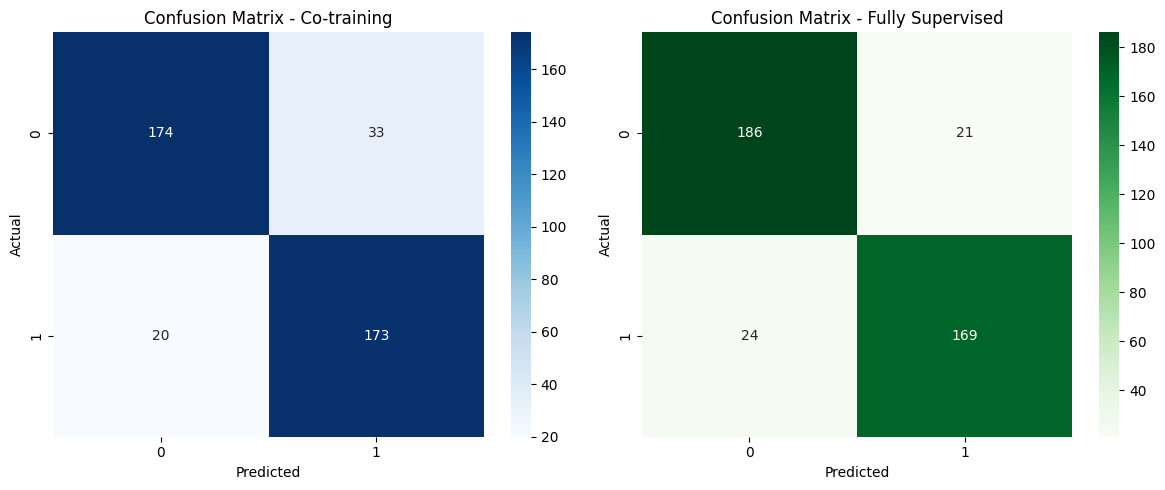

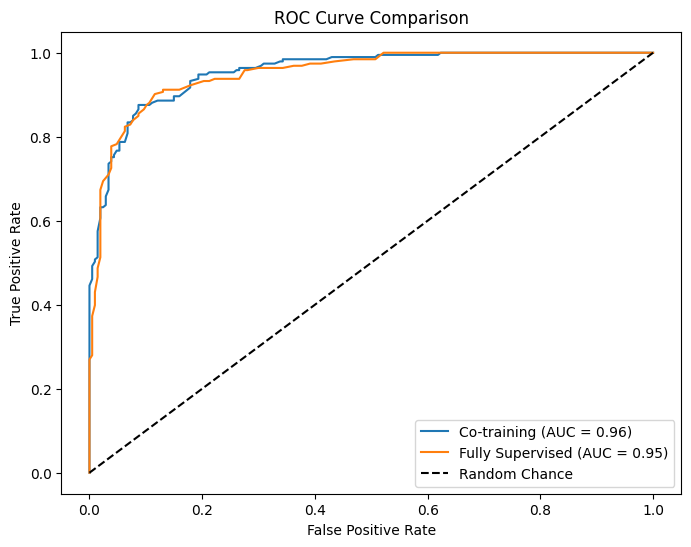

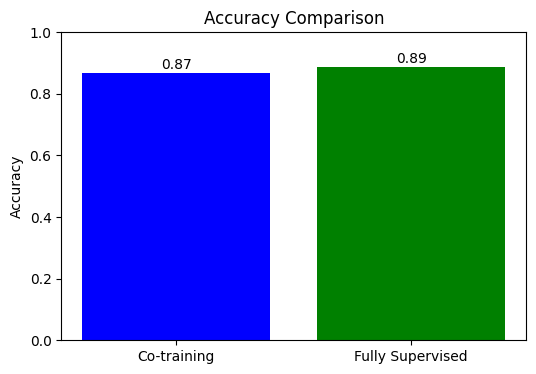

In [11]:
# -----------------------------
# 7. Evaluation and Visualization
# -----------------------------
# Classification Reports
print("Classification Report - Co-training Model:\n")
print(classification_report(y_test, y_pred_cotrain))
print("Classification Report - Fully Supervised Model:\n")
print(classification_report(y_test, y_pred_supervised))

# Accuracy Scores
acc_cotrain = accuracy_score(y_test, y_pred_cotrain)
acc_supervised = accuracy_score(y_test, y_pred_supervised)
print("Accuracy - Co-training:", acc_cotrain)
print("Accuracy - Fully Supervised:", acc_supervised)

# Confusion Matrices
cm_cotrain = confusion_matrix(y_test, y_pred_cotrain)
cm_supervised = confusion_matrix(y_test, y_pred_supervised)

fig, axes = plt.subplots(1, 2, figsize=(12, 5))
sns.heatmap(cm_cotrain, annot=True, fmt='d', ax=axes[0], cmap='Blues')
axes[0].set_title("Confusion Matrix - Co-training")
axes[0].set_xlabel("Predicted")
axes[0].set_ylabel("Actual")

sns.heatmap(cm_supervised, annot=True, fmt='d', ax=axes[1], cmap='Greens')
axes[1].set_title("Confusion Matrix - Fully Supervised")
axes[1].set_xlabel("Predicted")
axes[1].set_ylabel("Actual")
plt.tight_layout()
plt.show()

# ROC Curves
# Co-training ROC using averaged probabilities
fpr_cotrain, tpr_cotrain, _ = roc_curve(y_test, avg_proba_test[:, 1])
roc_auc_cotrain = auc(fpr_cotrain, tpr_cotrain)

# Fully supervised ROC
proba_supervised = supervised_clf.predict_proba(X_test)
fpr_supervised, tpr_supervised, _ = roc_curve(y_test, proba_supervised[:, 1])
roc_auc_supervised = auc(fpr_supervised, tpr_supervised)

plt.figure(figsize=(8, 6))
plt.plot(fpr_cotrain, tpr_cotrain, label=f'Co-training (AUC = {roc_auc_cotrain:.2f})')
plt.plot(fpr_supervised, tpr_supervised, label=f'Fully Supervised (AUC = {roc_auc_supervised:.2f})')
plt.plot([0,1], [0,1], 'k--', label='Random Chance')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison')
plt.legend(loc='lower right')
plt.show()

# Accuracy Comparison Bar Plot
fig, ax = plt.subplots(figsize=(6,4))
bars = ax.bar(['Co-training', 'Fully Supervised'], [acc_cotrain, acc_supervised],
              color=['blue', 'green'])
ax.set_ylim(0, 1)
ax.set_ylabel('Accuracy')
ax.set_title('Accuracy Comparison')
for bar in bars:
    height = bar.get_height()
    ax.annotate(f'{height:.2f}', xy=(bar.get_x() + bar.get_width()/2, height),
                xytext=(0, 3), textcoords='offset points', ha='center')
plt.show()
